<a href="https://polly.elucidata.io/manage/workspaces?action=open_polly_notebook&amp;source=github&amp;path=ElucidataInc%2Fpolly-python%2Fblob%2Fmain%2Fpolly_demo_days%2FExploring_single_cell_data_on_GEO.ipynb&amp;kernel=elucidata%2FSingle-cell+Downstream&amp;machine=large" target="_parent"><img alt="Open in Polly" src="https://elucidatainc.github.io/PublicAssets/open_polly.svg"/></a>


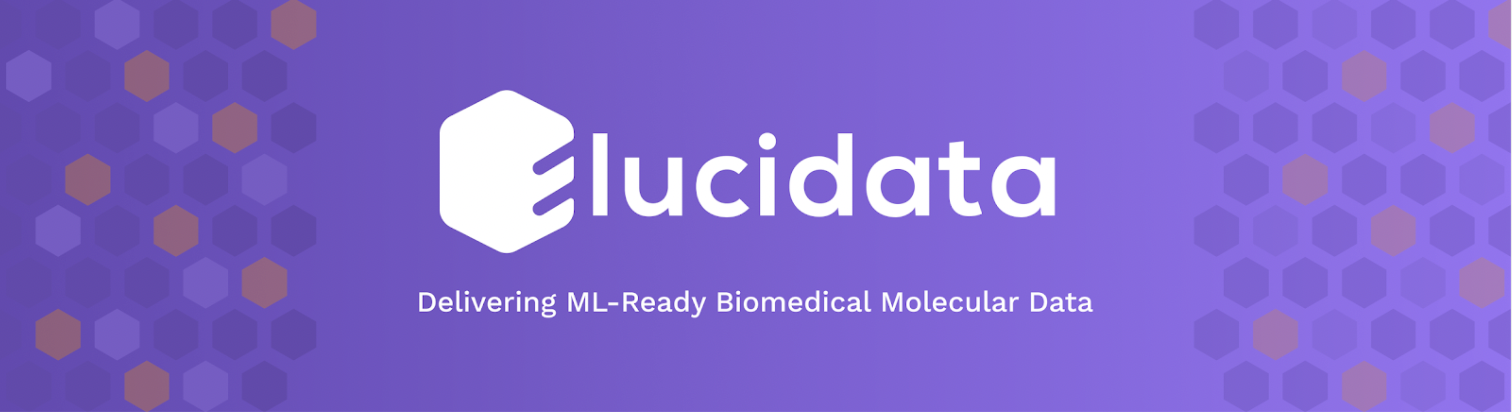

# Polly Python Demo

In today's demo we will
- Learn about data schema on Polly
- Browse the GEO and Single Cell Omix Atlas
- Identify a dataset of interest with both data types
- Download and parse a gct file for dataset of interest

For any support or feedback, kindly reach out to either krutika.gaonkar@elucidata.io or mya.steadman@elucidata.io

### Set up

Polly Python library provides convenient access to data in OmixAtlas through functions in Python language. <br> Polly Python can be installed via `pip3 install polly-python` <br> In any computational platform (like DataBricks, SageMaker, Polly) or your local environment.

https://docs.elucidata.io/OmixAtlas/Polly%20Python.html


In [2]:
# please do not modify
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [5]:
!sudo pip3 install polly-python

Looking in indexes: https://pypi.org/simple, http://54.245.179.143:80/
     |████████████████████████████████| 8.6MB 8.5MB/s eta 0:00:01
     |████████████████████████████████| 235kB 93.2MB/s eta 0:00:01
     |████████████████████████████████| 133kB 93.8MB/s eta 0:00:01
     |████████████████████████████████| 184kB 88.6MB/s eta 0:00:01
     |████████████████████████████████| 51kB 57.6MB/s eta 0:00:01
     |████████████████████████████████| 153kB 94.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 62.1MB/s eta 0:00:01
     |████████████████████████████████| 153kB 69.9MB/s eta 0:00:01
     |████████████████████████████████| 143kB 98.4MB/s eta 0:00:01
     |████████████████████████████████| 512kB 95.2MB/s eta 0:00:01
     |████████████████████████████████| 81kB 69.7MB/s eta 0:00:01
     |████████████████████████████████| 81kB 68.7MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp36-none-any.whl size=11431 sha256=de7256ce73e72b2f725720b6ca521f986b74a754

    Uninstalling boto3-1.17.19:
      Successfully uninstalled boto3-1.17.19
  Found existing installation: chardet 3.0.4
    Uninstalling chardet-3.0.4:
      Successfully uninstalled chardet-3.0.4
  Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20
  Found existing installation: idna 2.8
    Uninstalling idna-2.8:
      Successfully uninstalled idna-2.8
  Found existing installation: pytz 2019.3
    Uninstalling pytz-2019.3:
      Successfully uninstalled pytz-2019.3
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
restartkernel() #Pause for a few seconds before the kernel is refreshed

In [1]:
# please do not modify
from IPython.display import HTML
HTML('''<script type="text/javascript"> Jupyter.notebook.kernel.execute("url = '" + window.location + "'", {}, {}); </script>''')

#### Import libraries

In [4]:
# Import required libraries
from polly.omixatlas import OmixAtlas
from polly.auth import Polly

# For data wrangling and display
import pandas as pd
from json import dumps
import os
import re
from IPython.display import HTML

# To parse gct files
from cmapPy.pandasGEXpress.parse import parse


#### Add authentication
Authentication of the account is required to be able to access the capabilities of the Polly Python library.

In [5]:
AUTH_TOKEN=(os.environ['POLLY_REFRESH_TOKEN']) # Obtain authentication tokens
Polly.auth(AUTH_TOKEN)

In [6]:
library_client = OmixAtlas(AUTH_TOKEN)

### Data Schema
The data available within OmixAtlas is curated within 3 indexes/tables on the basis of the information it contains. These three indexes are:

**Dataset level metadata** (index: files): Contains curated fields like drug, disease, tissue organism, etc for each dataset.

**Sample level metadata** (index: gct_metadata): As the name suggests, this contains sample level metadata information for all samples except single-cell samples. It contains curated fields like cell lines, experimental design, etc for each sample except single-cell samples.

**Feature level metadata** (index: gct_data): This table contains feature level metadata information for all data except single-cell. It contains the gene/molecule symbol along with the feature intensity for each sample.

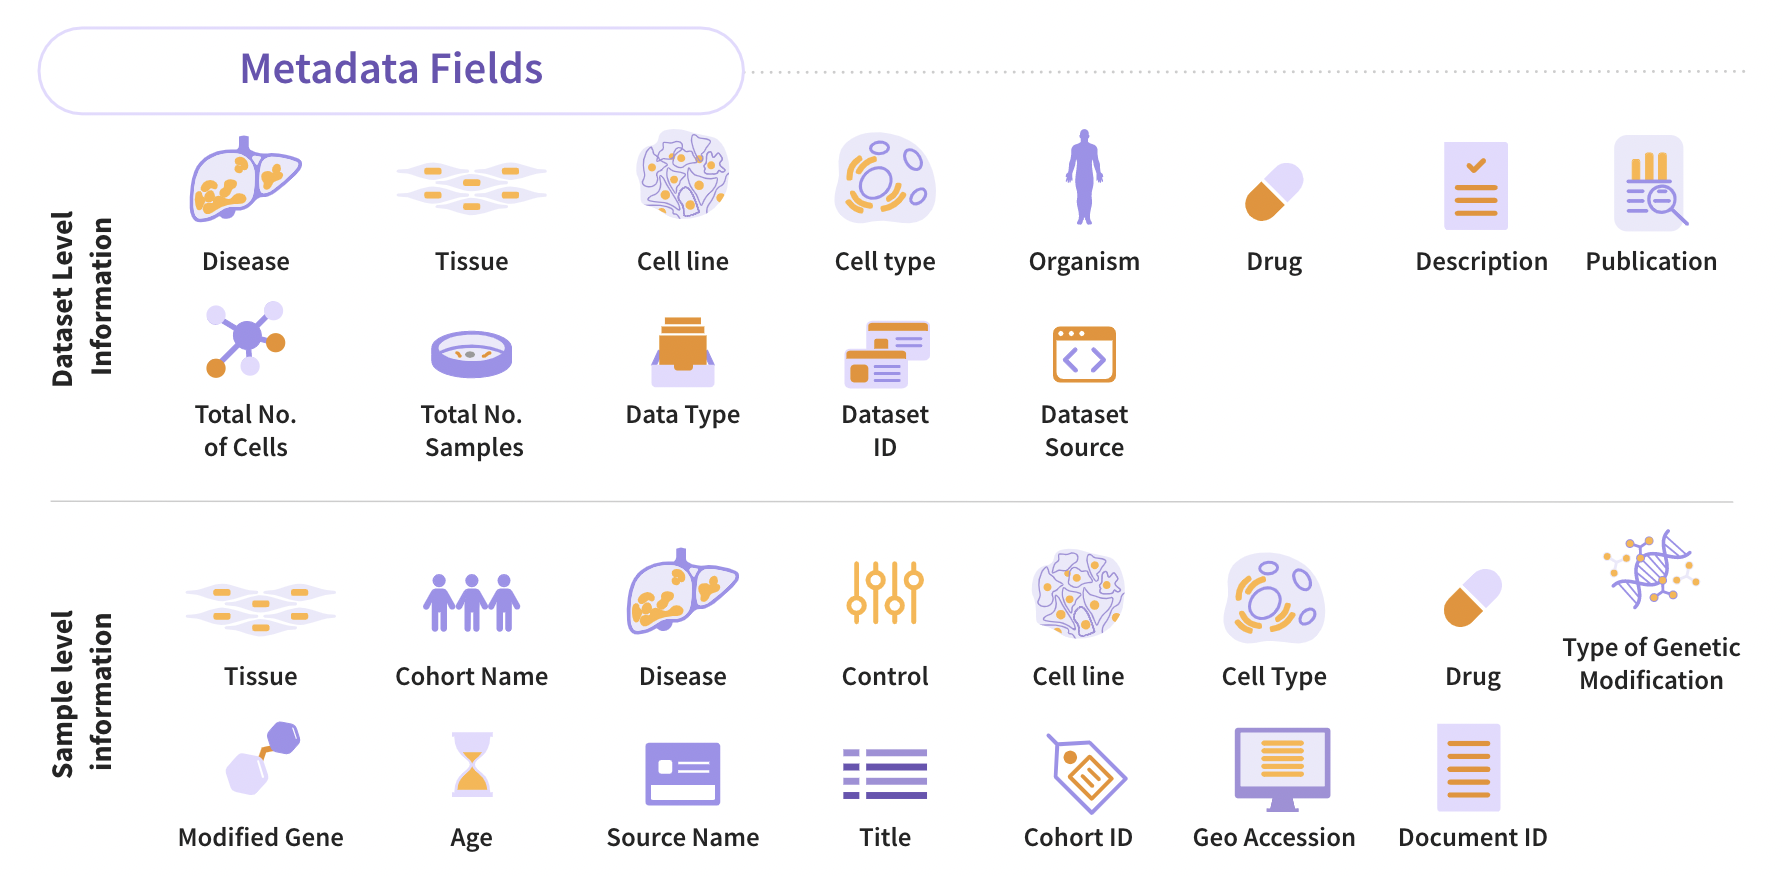


#### Set options

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Browsing data on Polly  


Publicly available data has a wide scope for reuse to accelerate our understanding of human diseases. 
However, accessing large amounts of public data, the process to make it useable and interoperable 
requires time, resources and expertise which hinder the pace of discovery. OmixAtlas on Polly aims to
address these issues by providing programmatic access to ML-ready biology-centric data from public repositories.

https://polly.elucidata.io/manage/omixatlas
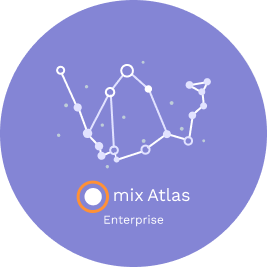

In [5]:
all_omixatlas=library_client.get_all_omixatlas()

In [44]:
# Display repository name and data types
df = pd.json_normalize(all_omixatlas, 'data')
print (df[['repo_name','datatypes']])

           repo_name                                          datatypes
1                hpa     [transcriptomics, gene expression reliability]
2                gdc  [mirna expression, transcriptomics, copy numbe...
3                geo      [transcriptomics, raw counts transcriptomics]
4   enterprise_atlas    [transcriptomics, single cell, mutation, mirna]
5    liveromix_atlas  [transcriptomics, mutation, metabolomics, sing...
6         cbioportal  [mutation, copy number variation, fusion, tran...
7                pcd                                    [drug response]
8              lincs                                  [transcriptomics]
9       metabolomics            [metabolomics, lipidomics, single cell]
10      sc_data_lake                                      [single cell]
11               etx                                  [transcriptomics]
12              gtex                                  [transcriptomics]


#### Querying across repositories 

Query *GEO and single cell Omix Atlas* at dataset level metadata to find datasets of interest:
- Where disease is <b>Breast Neoplasms</b>
- AND cell type is <b>T cell</b>

<div>
   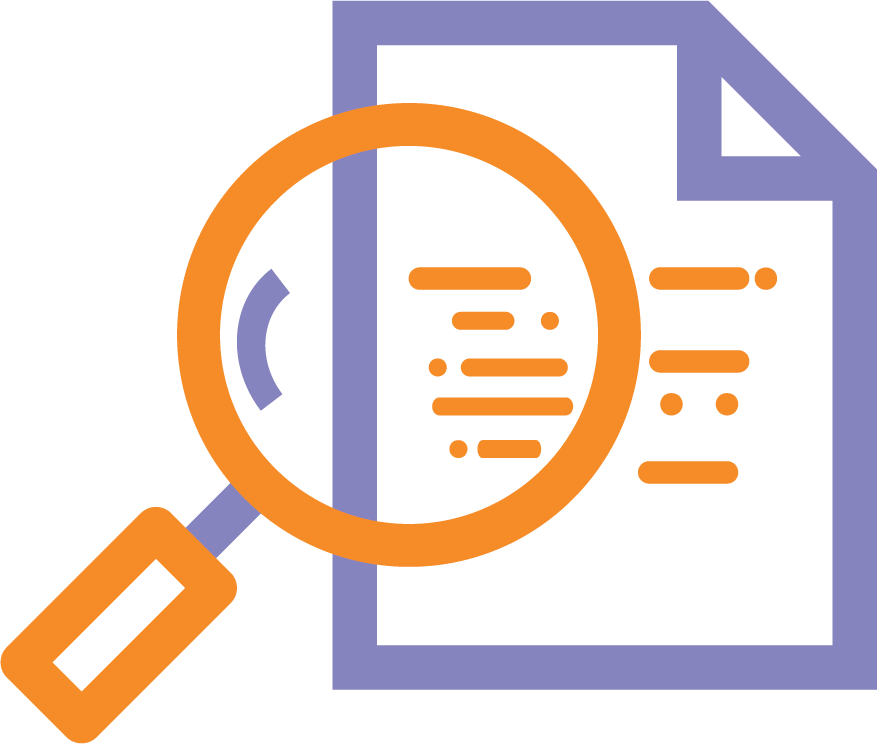
</div>


In [8]:
# Add repository names to search across
list_repo=['geo','sc_data_lake']
dataset_search_results = pd.DataFrame([])

for repo in list_repo:
     try:
        repo_name = repo
        # query to identify datasets studying Tcells  in Breast Neoplasms 
        query="SELECT * FROM "+repo+"_files WHERE disease='Breast Neoplasms' AND (kw_cell_type='T cell') LIMIT 2000"
        
        df = library_client.query_metadata(query)
        keep_cols = ["dataset_id", "description", "organism", "publication_title","kw_cell_type","kw_gene","kw_data_type","kw_cell_line","disease","kw_repo","publication","tissue"]
        df=df[df.columns[df.columns.isin(keep_cols)]]
        dataset_search_results=dataset_search_results.append(df)
     except:
         print(repo)

Query execution succeeded
Fetched 33 rows
Query execution succeeded
Fetched 9 rows


### Dataset of interest
We are interested in transcriptomics and single cell data associated with this paper.
https://www.sciencedirect.com/science/article/pii/S0092867418307232


#### Highlights
---
• Single-cell RNA-seq reveals phenotypic expansion of intratumoral immune cells

• Combined with gene expression data, perform immune cell classification and derived insights regarding the cell states

![Graphical_abstract](https://ars.els-cdn.com/content/image/1-s2.0-S0092867418307232-fx1.jpg)


#### Deposited Data
--- 

Description | ID
--- | ---
inDrop single-cell RNA-seq dataset	| GSE114725
10X paired single-cell TCR and RNA-seq dataset | GSE114724
CyTOF dataset	|  https://flowrepository.org/id/FR-FCM-ZYJP



### Query *sc_data_lake_h5ad_metadata* to identify all samples associated with `GSE114724` 

In [18]:
geo_sample_search_results=library_client.query_metadata( """SELECT *
                                                        FROM sc_data_lake_h5ad_metadata 
                                                        WHERE MATCH_QUERY(kw_doc_id,'GSE114724_GPL18573')""")
geo_sample_search_results

Query execution succeeded
Fetched 100 rows


,sample,platform,title,characteristics_ch1,source_name_ch1,batch,umi_counts,umi_counts_log,gene_counts,gene_counts_log,percent_mito,clusters,kw_curated_cell_type_x,kw_curated_cell_line,kw_curated_disease,kw_curated_drug,kw_curated_tissue,kw_curated_cell_type_y,kw_curated_raw_cell_type,kw_curated_marker_present,kw_curated_marker_absent,curated_cell_ontology_id,kw_column,kw_timestamp,kw_doc_id
0,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,3497.0,3.5438199043273926,1433,3.1565491513317814,0.07120388746261597,6,CD8 T cells,none,Breast Neoplasms,none,breast,"CD8-positive, alpha-beta T cell",CD8 T cells,CD8 T cells - Cd8a,None,CL:0000625,GSM3148577:CTGCCTAGTGAAGGCT,1645698932842,discover-prod-datalake-v1@@@sc_data_lake@@data...
1,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,5222.0,3.7179200649261475,1835,3.2638726768652235,0.0392569899559021,6,CD8 T cells,none,Breast Neoplasms,none,breast,"CD8-positive, alpha-beta T cell",CD8 T cells,CD8 T cells - Cd8a,None,CL:0000625,GSM3148577:CTGCCTAGTGCACTTA,1645698932842,discover-prod-datalake-v1@@@sc_data_lake@@data...
2,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,5106.0,3.7081658840179443,1851,3.2676409823459154,0.07677242159843445,6,CD8 T cells,none,Breast Neoplasms,none,breast,"CD8-positive, alpha-beta T cell",CD8 T cells,CD8 T cells - Cd8a,None,CL:0000625,GSM3148577:CTGCCTAGTGTGAATA,1645698932843,discover-prod-datalake-v1@@@sc_data_lake@@data...
3,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,4887.0,3.689131259918213,1613,3.2079035303860515,0.038878656923770905,0,CD4 T cells,none,Breast Neoplasms,none,breast,CD4-positive helper T cell,CD4 T cells,CD4 T cells - Cd4,None,CL:0000492,GSM3148577:CTGCCTATCTCGATGA,1645698932843,discover-prod-datalake-v1@@@sc_data_lake@@data...
4,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,2401.0,3.380573034286499,1170,3.068556895072363,0.07496876269578934,3,CD4 T cells,none,Breast Neoplasms,none,breast,CD4-positive helper T cell,CD4 T cells,CD4 T cells - Cd4,None,CL:0000492,GSM3148577:CTGCGGAAGACGCAAC,1645698932844,discover-prod-datalake-v1@@@sc_data_lake@@data...
5,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,4004.0,3.602602481842041,1450,3.161667412437736,0.040459539741277695,3,CD4 T cells,none,Breast Neoplasms,none,breast,CD4-positive helper T cell,CD4 T cells,CD4 T cells - Cd4,None,CL:0000492,GSM3148577:CTGCGGAGTTATGTGC,1645698932847,discover-prod-datalake-v1@@@sc_data_lake@@data...
6,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,20218.0,4.305759906768799,4684,3.670709595223797,0.056039173156023026,8,CD4 T cells,none,Breast Neoplasms,none,breast,CD4-positive helper T cell,CD4 T cells,CD4 T cells - Cd4,None,CL:0000492,GSM3148577:CTGCTGTAGTTGAGTA,1645698932848,discover-prod-datalake-v1@@@sc_data_lake@@data...
7,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,8604.0,3.93475079536438,2685,3.4291060083326967,0.06299395859241486,3,CD4 T cells,none,Breast Neoplasms,none,breast,CD4-positive helper T cell,CD4 T cells,CD4 T cells - Cd4,None,CL:0000492,GSM3148577:CTGCTGTCACAGGCCT,1645698932849,discover-prod-datalake-v1@@@sc_data_lake@@data...
8,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,3614.0,3.558108329772949,1322,3.1215598441875008,0.05534034222364426,0,CD4 T cells,none,Breast Neoplasms,none,breast,CD4-positive helper T cell,CD4 T cells,CD4 T cells - Cd4,None,CL:0000492,GSM3148577:CTGCTGTCATCCGCGA,1645698932850,discover-prod-datalake-v1@@@sc_data_lake@@data...
9,GSM3148577,GPL18573,BC10_TUMOR1,donor: BC10|||cell type: CD3+ leukocytes|||don...,CD3+ leukocytes,0,4293.0,3.632862091064

### Query *geo_gct_metadata* to identify all samples associated with `GSE114725` 

In [19]:
geo_sample_search_results=library_client.query_metadata( """SELECT *
                                                        FROM geo_gct_metadata 
                                                        WHERE MATCH_QUERY(kw_doc_id,'GSE114725')""")
geo_sample_search_results

Query execution succeeded
Fetched 43 rows


,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,characteristics_ch1_1,characteristics_ch1_2,molecule_ch1,extract_protocol_ch1,extract_protocol_ch1_1,extract_protocol_ch1_2,taxid_ch1,data_processing,data_processing_1,data_processing_2,platform_id,contact_name,contact_laboratory,contact_department,contact_institute,contact_address,contact_city,contact_state,contact_zip_postal_code,contact_country,data_row_count,instrument_model,library_selection,library_source,library_strategy,relation,relation_1,supplementary_file_1,cell_type_ch1,donor_age__years__ch1,resident_tissue_ch1,kw_curated_cell_line,kw_curated_cell_type,kw_curated_disease,kw_curated_drug,kw_curated_tissue,kw_curated_genetic_mod_type,kw_curated_modified_gene,curated_min_age,curated_max_age,curated_age_unit,kw_curated_gender,curated_is_control,curated_cohort_id,curated_cohort_name,kw_column,kw_timestamp,kw_doc_id
0,BC02_NORMAL1,GSM3148601,Public on Jun 28 2018,May 21 2018,Jun 28 2018,SRA,1,BC02,Homo sapiens,cell type: CD45+ leukocytes,donor age (years): 60,resident tissue: breast,polyA RNA,InDrop v2,CD45+ cells from breast were isolated by minci...,Sequencing libraries were prepared following t...,9606,InDrop v2 RNA-seq data was processed from raw ...,Genome_build: Gencode GRCh38,Supplementary_files_format_and_content: Cell x...,GPL16791,"Ambrose,J,Carr",Dana Pe'er,"Computational and Systems Biology Program, SKI",Memorial Sloan Kettering Cancer Center,417 E 68th St,New York,NY,10065,USA,0,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3148...,CD45+ leukocytes,60,breast,none,leukocyte,Normal,none,breast,wildtype,none,60.0,60.0,Years,none,1,1,breast,GSM3148601,1642015334773,discover-prod-datalake-v1@@@GEO_data_lake@@dat...
1,BC01_TUMOR2,GSM3148592,Public on Jun 28 2018,May 21 2018,Jun 28 2018,SRA,1,BC01,Homo sapiens,cell type: CD45+ leukocytes,donor age (years): 38,resident tissue: breast tumor,polyA RNA,InDrop v2,CD45+ cells from tumor were isolated by mincin...,Sequencing libraries were prepared following t...,9606,InDrop v2 RNA-seq data was processed from raw ...,Genome_build: Gencode GRCh38,Supplementary_files_format_and_content: Cell x...,GPL16791,"Ambrose,J,Carr",Dana Pe'er,"Computational and Systems Biology Program, SKI",Memorial Sloan Kettering Cancer Center,417 E 68th St,New York,NY,10065,USA,0,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3148...,CD45+ leukocytes,38,breast tumor,none,leukocyte,Breast Neoplasms,none,breast,wildtype,none,38.0,38.0,Years,none,0,2,breast tumor,GSM3148592,1642015334788,discover-prod-datalake-v1@@@GEO_data_lake@@dat...
2,BC06_TUMOR2,GSM3148632,Public on Jun 28 2018,May 21 2018,Jun 28 2018,SRA,1,BC06,Homo sapiens,cell type: CD45+ leukocytes,donor age (years): 58,resident tissue: breast tumor,polyA RNA,InDrop v2,CD45+ cells from tumor were isolated by mincin...,Sequencing libraries were prepared following t...,9606,InDrop v2 RNA-seq data was processed from raw ...,Genome_build: Gencode GRCh38,Supplementary_files_format_and_content: Cell x...,GPL16791,"Ambrose,J,Carr",Dana Pe'er,"Computational and Systems Biology Program, SKI",Memorial Sloan Kettering Cancer Center,417 E 68th St,New York,NY,10065,USA,0,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3148...,CD45+ leukocytes,58,breast tumor,none,leukocyte,Breast Neoplasms,none,breast,wildtype,none,58.0,58.0,Years,none,0,2,breast tumor,GSM3148632,1642015334790,discover-prod-datalake-v1@@@GEO_data_lake@@dat...
3,BC04_TUMOR1,GSM3148621,Public on Jun 28 2018,May 21 2018,Jun 28 2018,SRA,1,BC04,

### Download gct file for the dataset of interest 
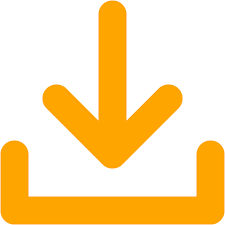

#### Parsing gct file format
Class representing parsed gct(x) objects are pandas dataframes. 

Contains 3 component dataframes 
- row_metadata_df : row names in RNAseq gct file
- column_metadata_df : sample metadata in RNAseq gct file 
- and data_df : count matrix


In [20]:
dataset = "GSE114725_GPL16791"
# Gather url
url = library_client.download_data("geo", dataset).get('data')['attributes']['download_url']
ext = ".gct"
file_name = dataset+ext

# Download file
if not os.path.isfile(file_name):
    os.system(f"curl -o '{file_name}' '{url}'")

# Parse gct file    
try:
    data=parse(file_name)
except KeyboardInterrupt:
    print ('parsing failed')
else:
    col_meta_data = data.col_metadata_df
    row_meta_data = data.row_metadata_df  


In [21]:
data.data_df.loc[data.row_metadata_df.index=="BRCA2"]

cid,GSM3148619,GSM3148623,GSM3148601,GSM3148614,GSM3148620,GSM3148593,GSM3148595,GSM3148615,GSM3148629,GSM3148590,GSM3148635,GSM3148604,GSM3148602,GSM3148618,GSM3148586,GSM3148628,GSM3148603,GSM3148587,GSM3148592,GSM3148626,GSM3148639,GSM3148632,GSM3148637,GSM3148624,GSM3148596,GSM3148591,GSM3148600,GSM3148621,GSM3148594,GSM3148599,GSM3148622,GSM3148589,GSM3148616,GSM3148625,GSM3148634,GSM3148605,GSM3148588,GSM3148598,GSM3148617,GSM3148631,GSM3148638,GSM3148597,GSM3148633
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRCA2,4.845,2.591,2.7182,5.4403,1.7114,3.2291,6.5457,4.486,6.1669,4.2519,4.6412,5.9036,2.8712,4.1207,5.2317,5.8441,4.8784,4.549,1.1668,2.8712,5.656,6.6062,5.3792,3.9963,5.105,5.9237,5.5358,4.0547,3.6363,7.7577,4.2351,3.0061,4.1727,2.9712,6.7549,6.1601,6.3474,5.1182,5.1494,6.6999,4.7492,4.4161,6.2839


Downloaded metadata and counts matrix can be used for downstream analysis like:

Boxplots visualizing the distribution of gene expression

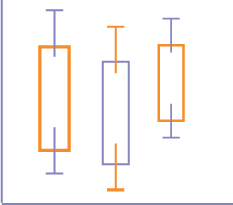


Perform differential expression by identifying cohorts in the sample level metadata

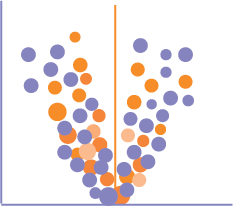